# Initialise

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices, Treatment
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm, glm
import scipy.stats as stats
import numpy as np
from copy import deepcopy
from math import sqrt


a = pd.read_csv('course_marks.csv')
b = pd.read_csv('awards.csv')

a = a.rename(columns={'Fee_status':'Fee status'})
b = b.rename(columns={'Fee_status':'Fee status'})

# For plotting we work with average course marks rather than all course marks otherwise the
# error bars will be too small. And also that is how the statistical models work by aggregating
# by student ID

# Order the categories
ethnicity_order = ['White', 'Chinese', 'Mixed', 'Asian', 'Black']
fee_status_order = ['EU', 'RestUK+RoI', 'Overseas', 'Scottish']

# Convert Year so that the project has its own level called "Project"
a['Year'] = a.apply(lambda x: 'Project' if x['Project'] else x['Year'], axis=1)

# Get average marks for each student for each year/project.
# Calculate the average White course mark by fee status and year and subtract that from all course marks
ave_marks = a.groupby(['ID', 'Year'])['Mark'].mean()
ave_marks = ave_marks.reset_index().merge(b, on=['ID'])

white_mean_mark_by_year_by_fee = ave_marks.query('Ethnicity == "White"').groupby(['Year', 'Fee status'])['Mark'].mean().rename('Ave_Mark')
ave_marks = ave_marks.merge(white_mean_mark_by_year_by_fee, on=['Year', 'Fee status'], how='left')
ave_marks['Mark_rel_White'] = ave_marks['Mark'] - ave_marks['Ave_Mark']
ave_marks = ave_marks.drop('Ave_Mark', axis=1)

# Plotting order and styles 
colour_order = ['C0', 'C1', 'C2', 'C3']
colours = dict([(s, c) for s, c in zip(fee_status_order, colour_order)])
ls = ['-', '-.', ':', '--', '-']
markers = list('ospv^')

sns.set_style("whitegrid")
sns.set_context("talk")

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [ ]:
fee_status_order = ['EU', 'RestUK+RoI', 'Overseas', 'Scottish']

sns.set_context("talk")
g = sns.catplot(y='Mark_rel_White', x='Year', col='Fee status', order=year_order, col_order=fee_status_order, kind='point', errwidth=1, ci=68, data=ave_marks.query('ethnicity == "BAME"'))
g.set_ylabels('BAME mark relative to White');
g.set_xticklabels(['$1^{st}$', '$2^{nd}$', '$3^{rd}$', '$4^{th}$', 'Honours\nProject']);
sns.despine(bottom=True)
for ax in g.axes[0]:
    ax.axhline(0, color='k', linewidth=2)


# Report

## Context

In order to get a clearer picture of the factors associated with differences in performance and attainment between White and BAME students, I obtained from Student Analytics, Insights and Modelling (SAIM) all course marks and awards of undergraduate students who achieved a Biological Sciences exit award in the last 5 years (academic sessions 2015/16 - 2019/20). For each student we have their fee status, their ethnicity, their final degree classification and all of their course marks.

The data are used to answer two questions:
1. Does ethnicity affect performance throughout a student's studies?
2. Does ethnicity affect final year course and project marks which therefore affects degree classification?

In order to answer these questions we need to control for fee status, which is known to affect student performance, and year of study, as average marks change by year (see Methods). The Final year project is also treated as a factor as it is assessed differently to course marks. In addition, an individual student's course marks are not independent: the course marks of a good student are generally higher than those for a poor student. This means we need to use a linear mixed effect model to analyse course marks with anonymised student ID as a random effect.

## Effect of ethinicity on course marks for each year of study

Fig. 1 shows average course and project marks for non-EU BAME students relative to White students over the course of their studies. At the end of first year there is no effect of ethnicity on 1st year course marks (chisq_4=4.3, p=0.37).

For the next three years non-EU BAME students' marks relative to White students' marks drop by about 1.7 points each year. So that by 4th year BAME students are about 5 points lower than white students.

The difference in Honours Project marks is similar to that in 4th year course marks.

Course marks for EU students do not change significantly over time (chisq_3=2.7, p=0.43) so are not included in the Fig. 1.

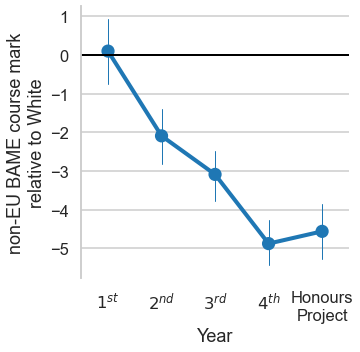

In [24]:
g = sns.catplot(y='Mark_rel_White', x='Year', kind='point', errwidth=1, ci=68, markers=markers, linestyles=ls, orient='v', data=ave_marks.query('ethnicity == "BAME"'))
g.set_ylabels('non-EU BAME course mark\nrelative to White')
g.set_xticklabels(['$1^{st}$', '$2^{nd}$', '$3^{rd}$', '$4^{th}$', 'Honours\nProject']);
sns.despine(bottom=True)
for ax in g.axes[0]:
    ax.axhline(0, color='k', linewidth=2)

Fig. 1 Effect of ethnicity on course and project marks relative to White of the same fee status by year of study. Error bars represent one standard error.

## Effect of ethnicity on 4th year course marks

It is worth looking at 4th year BAME course marks relative to White broken down by fee status and ethnicity to see differences between the categories and interactions between the two factors (Fig. 2).

For EU students, there is no effect of ethnicity on 4th year course marks (chisq_3=1.7, p=0.64). But for all other fee status groups, BAME significantly reduces 4th year course marks by about 4.6 points (chisq_4=44.0, p<0.001).

However, there are interactions between fee status and ethnicity. In particular, Overseas Black students do particularly poorly, with course marks significantly smaller by an additional 6.4 points (t=2.6, p=0.01).

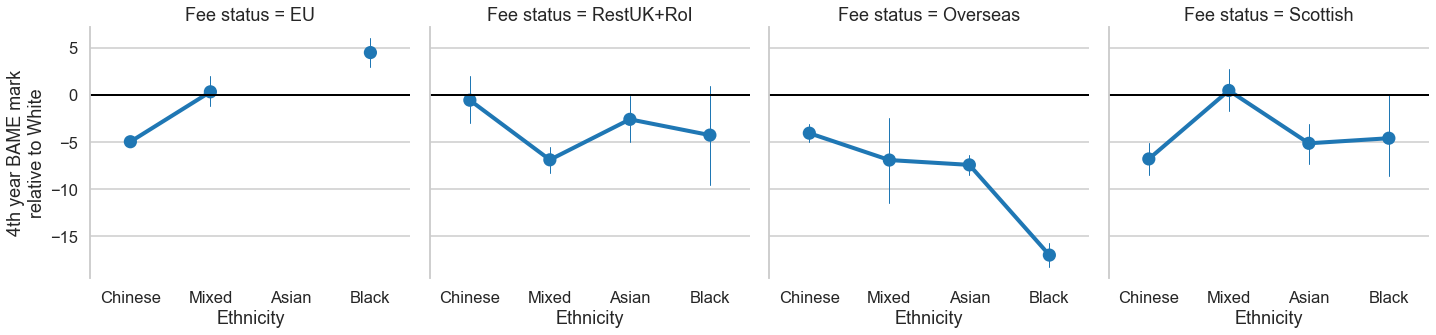

In [25]:
ethnicity_order = ['Chinese', 'Mixed', 'Asian', 'Black']

g = sns.catplot(y='Mark_rel_White', x='Ethnicity', col='Fee status', order=ethnicity_order, col_order=fee_status_order, kind='point', errwidth=1, ci=68, markers=markers, linestyles=ls, orient='v', data=ave_marks.query('ethnicity == "BAME" and Year == 4'))
g.set_ylabels('4th year BAME mark\nrelative to White');
sns.despine(bottom=True)
for ax in g.axes[0]:
    ax.axhline(0, color='k', linewidth=2)

Fig. 2 Effect of ethnicity and fee status on 4th year course marks (excluding Honours Project) relative to White of the same fee status. Error bars represent one standard error.

## Effect of ethnicity on Honours Project

Honour year project marks of BAME relative to White students are broken down by fee status and ethnicity in Fig. 3.  

For EU students, there is no effect of ethnicity on project mark (F_3, 128=0.20, p=0.9). For all other fee status groups, project marks for Asian students are 4.8 points lower than White students (t=3.9, p<0.001) and for Black students they are 12.8 points lower (t=6.4, p<0.001). The effect for Chinese and Mixed ethnic students is marginal at about 2-3 points (t=1.8, p=0.07, and t=1.9, p=0.06, respectively).

There is no interaction between fee status and ethnicity for non-EU students (F_8,596=1.6, p=0.13). But it is clear that some Overseas Black students perform particularly poorly.

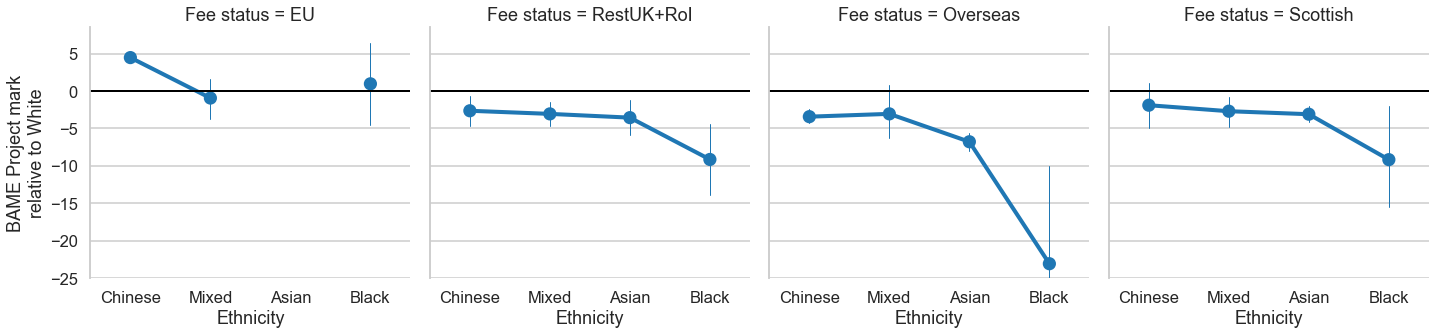

In [26]:
ethnicity_order = ['Chinese', 'Mixed', 'Asian', 'Black']

g = sns.catplot(y='Mark_rel_White', x='Ethnicity', col='Fee status', order=ethnicity_order, col_order=fee_status_order, kind='point', errwidth=1, ci=68, markers=markers, linestyles=ls, orient='v', data=ave_marks.query('ethnicity == "BAME" and Year == "Project"'))
g.set_ylabels('BAME Project mark\nrelative to White');
g.set(ylim=(-25, None))
sns.despine(bottom=True)
for ax in g.axes[0]:
    ax.axhline(0, color='k', linewidth=2)

Fig. 3 Effect of ethnicity on Honours project marks relative to White of the same fee status. Error bars represent one standard error.

## Effect of ethnicity of percent high classifications

Around 75% to 85% of White, Mixed and Chinese students attain a high degree classification (Fig. 4). Whereas only about 50% of Asian and Black students acheive a high classification. This is a significant difference (z=4.0, p<0.001 and z=3.0, p=0.003 respectively).

Although there is a significant effect of fee status (mainly Scottish students, chisq_3=41.1, p<0.001), there is no significant interaction between fee status and ethnicity (chisq_11=9.0, p=0.62).

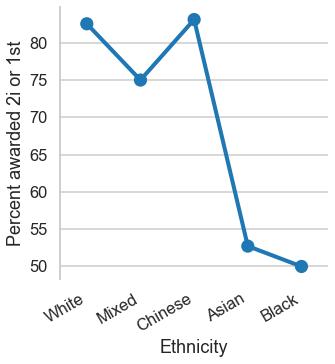

In [27]:
ethnicity_order = ['White', 'Mixed', 'Chinese', 'Asian', 'Black']

y = 'Percent awarded 2i or 1st'

p = b.groupby(['Ethnicity'])['high'].value_counts(normalize=True)
p = p.mul(100)
p = p.rename(y).reset_index()

g = sns.catplot(x='Ethnicity', y=y, order=ethnicity_order, kind='point', color='C0', data=p.query('high == True'))
g.set_xticklabels(rotation=30, ha='right');
sns.despine(bottom=True)


Fig. 4 Effect of ethnicity on percent high classification.

## Conclusions

At the beginning of their studies in the School, BAME students' course marks are as high as their white peers. Over the course of their studies, BAME students' course marks drop by about 1.7 percentage points each year relative to their white peers. Which means, by the end of 4th year, BAME students' course marks are about 4.6 percentage points below their white peers. 

However, there are important differences between fee status groups. EU BAME students perform as well, if not better, than their white peers. Overseas Black students perform exceptionally poorly.

For their final year Honours Project, Asian and Black students score about 5 and 13 percentage points lower than their white peers. Mixed and Chinese students also do slightly less well, although the difference is only marginally significant. 

The smaller effect of ethnicity on Honours project marks than 4th year course marks could be because the project dissertation is double, and sometimes triple marked. This averaging makes project marks less variable than course marks; so the project marks of poorer performing will be pulled closer to the mean.  

The Honours project is worth 40% of a student's final mark and so has a significant impact on their final degree classification. Asians, and particularly Black students perform significantly worse than other ethnicities. This might well explain why signifcanlty fewer Asian and Black students achieve a high classification compared to Mixed, Chinese and White students.

This points to an issue with using percent high classification as a measure of BAME attainment: it hides significant performance differences at course level across all BAME categories. It also hides the result that, when BAME students start their studies, they perform just as well as their white peers. It also hides ...

As black students are the poorest performing students, directing resources to them could be made a priority. Fortunately there is, on average, just three non-EU Black students in each cohort. Assigning them to our best Personal tutors (i.e., tutoes that are known to actively engage in their tutee's studies) may be beneficial. Similarly, on average, there are 11 non-EU Asian students in each cohort. Assigning them to our best PTs should not be too difficult. 

The results clearly show that performance drops over time. It is therefore important that the School catches poor performing BAME students early in their studies and direct help their way.

The statistical analysis shows that average fourth year course marks of Chinese students are significantly lower than White students, but that a similar proportion of them attain a high degree classification. This discrepancy could be due to several factors: 
1. Variability in course marks is also important. For example, if all students had an average course mark of 71% then all of them would achieve a 1st. But if some students had lower than 71% and others higher than 71% (but keeping the mean at 71%) some proportion of the students would not achieve a 1st.
2. Classification is based on a weighted sum of 3rd and 4th year marks, and the Honours project has a weight of 40%. 
3. For borderline students, final classification is also based subjective criteria discussed during Exam Boards, such as Special circumstances and improving marks over time.


---

Ethnicity statistics supplied to the School in various reports and within PowerBI shows a discrepancy between average course marks and the percentage of students awarded high degree classifications (i.e., 2.i and 1st). The average course mark from 2015/16 to 2019/20 of SBS BAME students is about 2 percentage-points lower than that of White students. Whereas the percentage of BAME students attaining a High degree classification is 69% compared to 83% for White students; a difference of 14%. 

First, this discrepancy is not as large as it seems because percent high classifications is sensitive to changes in mean course mark. This is because course marks are normally distributed rather, than say, uniformly distributed. For example, if White student course marks are normally distributed with a mean of 66% and a standard deviation of about 8%. A 2 percentage-point decrease in mean course mark causes an 8 percentage-point decrease in percent high classification (Fig. 1).

Another problem with interpreting the broad-brush statistics supplied to the School is that they do not take into account differences between fee status and year of study. These differences are substantial as shown Fig. 2 for course marks and percent high classification. Scottish students perform the worst. If a many Scottish students are BAME then, perhaps, BAME students perform poorly, not because they are BAME, but because they are Scottish.

SAIM do not distinguish between Overseas and EU students, instead grouping them under the category "NotUK". This is due to the quality of the data. For example, some students feel they do not fit into the catgories they can choose from and thus may chose "Other". However, for those students who do identify as either EU or Overseas, this analysis shows that there is a clear, stark and significant effect of ethnicity. 

The discrepancy between course marks and percent high classifications arises because BAME students progressively fall behind White students during their studies. The discrepancy disappears when only 3rd and 4th year courses are used to calculate average course marks.

<!-- Given the sensitivity if percent high classification to mean course mark, percent-high classifications are perhaps not an good metric to measure the performance of BAME students against White students. This is a real issue when the number of BAME students is low, because of  -->


For an individual student their average course marks determines their degree classification. But at the population level, there is not a perfect correlation between percent high classifications and average course marks for several reasons

Statistics have been presented on average course marks to compared between White and BAME. 

Trying to relate average course marks to percent high classification is problematic and not really necessary. However, course marks are useful in examining how factors correlate with student performance over the full course of their studies.

## Methods

Student Analytics, Insights and Modelling (SAIM) supplied an excel spreadsheet of all course marks, Honours project marks and exit awards of all undergraduate students who achieved a Biological Sciences exit award for academic sessions 2015/16 - 2019/20. Also included for each student was an anonymised ID, their fee status, their ethnicity and their programme of study. Marks for multiple sittings were included.

Before analysis the spreadsheet was cleaned as follows:
1. Any record with a missing course mark was removed.
2. Postgraduate courses taken in 4th year were recorded as 4th year courses.
3. Some students who had 3rd year abroad still had 3rd year courses with 0 marks. These were removed.
4. Where a student attempted a course multiple times, only the highest mark was kept.
5. Students without an ethnicity ("Not given" and "Prefer not to say") were excluded.
6. Course marks of 0% were excluded.

This last cleaning step is the most controversial. Although a course mark of 0% is valid, they are clear outliers when plotted against all other non-zero course marks (they create a bi-modal distribution with modes at 0% and about 65%). These marks create problems with the statistical models because the residuals then become non-normally distributed. So, for now, they are excluded until a better way is found to handle them.

In total 13% of records were removed and 8% of students. 
    
In order to have sufficient numbers of students in different ethnic categories, the categories supplied by SAIM were reduced according to the following table. There is, of course, some subjectivity in reducing the number of categories, but it is unlikely to effect the main outcomes of this analysis.

The single Arab student in the data was removed as it was not clear into which category they should be placed. The "Other Ethnic Background" category was placed in "Black" as it did not fit into the other categories.

Asian | Mixed | Chinese | Black | White | Not included
:--- | :--- | :--- | :--- | :--- | :---
Asian or Asian British - Bangladeshi | Mixed - White and Asian           | Chinese | Black or Black British - African  | White                  | Arab
Asian or Asian British - Indian      | Mixed - White and Black African   |         |Black or Black British - Caribbean | White - Other British  | Not given
Asian or Asian British - Pakistani   | Mixed - White and Black Caribbean |         |Other Ethnic Background            | White - Scottish       | Prefer not to say
Other Asian Background               | Other Mixed Background            |         |                                   | Other White Background |

It was not possible to provide for each student the year of their programme the course was taken. Instead the year the course is usually taken was given.

Gender, age, disability and schooling (State/Independent) were not in the data, but could have been supplied.

Table 1 shows the breakdown of student numbers by fee status and ethnicity. As there are no EU Asian students some of the statistical analysis treats EU students separately. This is not an issue as EU BAME students do as well, if not better, than their white peers.

It is instructive to look at the effects of year of study and fee status (Fig. 1). It is clear that both of these factors affect course marks. They must, therefore, must be controlled for when analysing the effect of ethnicity on course marks and awards.

As course marks are constrained in the interval 0 - 100 they are arcsine-sqrt transformed to make the residuals more normal. This transform makes negligible difference mainly because most marks are not at the extremes.

Statistical models of course marks were fit using R's "lme" linear mixed effect model to take into account non-independence of a student's course marks. The model fit to Honours project marks was a linear model and the Percent high classification was fit with standard logistic regression glm in R. 

Source code for data cleaning and statistical analysis are available at




In [28]:
t1 = pd.crosstab(b['Ethnicity'], b['Fee status'], margins=True)
t2 = pd.crosstab(b['Ethnicity'], b['Fee status'], margins=True, normalize='columns')
t1

Fee status,EU,Overseas,RestUK+RoI,Scottish,All
Ethnicity,,,,,
Asian,0,38,6,11,55
Black,2,4,4,6,16
Chinese,1,67,4,5,77
Mixed,5,5,12,10,32
White,126,40,191,239,596
All,134,154,217,271,776


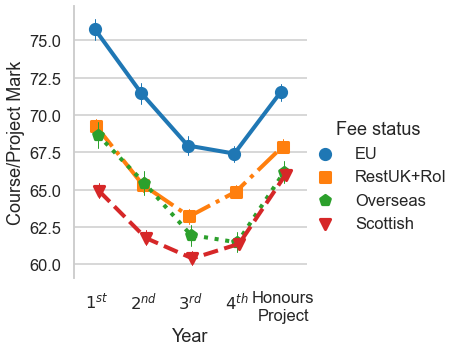

In [30]:
year_order = [1, 2, 3, 4, 'Project']

g = sns.catplot(x='Year', y='Mark', hue='Fee status', kind='point', errwidth=1, ci=68, dodge=True, markers=markers, linestyles=ls, order=year_order, hue_order=fee_status_order, palette=colours, data=ave_marks)
g.set_ylabels('Course/Project Mark');
g.set_xticklabels(['$1^{st}$', '$2^{nd}$', '$3^{rd}$', '$4^{th}$', 'Honours\nProject']);
sns.despine(bottom=True)

# x = 'Fee status'
# y = 'Percentage of students\nawarded 2i or 1st'

# p = b.groupby([x])['high'].value_counts(normalize=True)
# p = p.mul(100)
# p = p.rename(y).reset_index()

# g = sns.catplot(x=x, y=y, order=fee_status_order, kind='point', data=p.query('high == True'))
